In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import bz2

from GeoBases import GeoBase

%matplotlib inline


bookingsFile = r'./data/bookings.csv'
searchesFile = r'./data/searches.csv'

bookingsFileBz2 = r'./data/bookings.csv.bz2'
searchesFileBz2 = r'./data/searches.csv.bz2'

## Exercise 1: Count the number of lines in Python for each file

In [3]:
# Since input CSV files are large, they will be read by blocks 
# to get the number of lines contained in each of them

def readBlock(inFile, size=65536):
    """Read a block of size 'size' in 'inFile'"""
    while True:
        b = inFile.read(size)
        if not b: 
            break
        yield b

def countNbLines(inFile):
    """Count, by blocks, the number of lines in 'inFile'"""
    with open(inFile, 'r') as f:
        return sum(block.count("\n") for block in readBlock(f))
    

for i in [bookingsFile, searchesFile]:
    nbLines = countNbLines(i)
    print "Number of lines in file '{}': {}".format(os.path.basename(i), nbLines)

Number of lines in file 'bookings.csv': 10000011
Number of lines in file 'searches.csv': 20390198


## Exercise 2: Get top 10 arrival airports in the world in 2013 (using the bookings file)

In [5]:
# First get only first line of the CSV file in order to have the list of columns
df_bookings = pd.read_csv(bookingsFileBz2, compression='bz2', error_bad_lines=False, sep='^', nrows=1)

df_bookings

,act_date,source,pos_ctry,pos_iata,pos_oid,rloc,cre_date,duration,distance,dep_port,...,route,carrier,bkg_class,cab_class,brd_time,off_time,pax,year,month,oid
0,2013-03-05 00:00:00,1A,DE,a68dd7ae953c8acfb187a1af2dcbe123,1a11ae49fcbf545fd2afc1a24d88d2b7,ea65900e72d71f4626378e2ebd298267,2013-02-22 00:00:00,1708,0,ZRH,...,LHRZRH,VI,T,Y,2013-03-07 08:50:00,2013-03-07 11:33:37,-1,2013,3,NULL


In [6]:
# Then get index of columns 'arr_port' and 'pax' in order to load only those columns when loading the whole file
# This because entire file cannot be fully loaded due to memory limits
colList = df_bookings.columns.tolist()

# Create a sub-list of columns to be loaded
colSubList = list()
for i in ['arr_port', 'pax']:
    index = colList.index(i)
    colSubList.append(colList[index])

df_bookings = pd.read_csv(bookingsFileBz2, compression='bz2', error_bad_lines=False, sep='^', usecols=colSubList)
df_bookings.dropna()


# Group by airport, sum on 'pax' column and sort values in descending order
df_airport = df_bookings.groupby(['arr_port'], sort=False)['pax'].sum()
df_airport = df_airport.sort_values(ascending=False)

# Get top 10 airports
df_airport = df_airport[:10]

# 'Geobase' module will be used to get corresponding city or airport for each airport code in 'df_airport'
geo_airports = GeoBase(data='airports', verbose=False)

# And print
print "=== Top ten arrival airports in the world in 2013, with number of passengers ===\n"

listAirportsCode = df_airport.index.tolist()
d = {'Code': [i.strip() for i in listAirportsCode],
    'Airport': [geo_airports.get(airportCode.strip(), 'name', default='Unknown') for airportCode in listAirportsCode],
    'NbPass': df_airport.values.astype('int').tolist()
    }

df_topTen = pd.DataFrame(d, columns=['Code', 'Airport', 'NbPass'],index=range(1,11))
print(df_topTen)

del df_bookings

=== Top ten arrival airports in the world in 2013, with number of passengers ===

   Code                               Airport  NbPass
1   LHR               London Heathrow Airport   88809
2   MCO         Orlando International Airport   70930
3   LAX     Los Angeles International Airport   70530
4   LAS        McCarran International Airport   69630
5   JFK  John F Kennedy International Airport   66270
6   CDG             Paris - Charles-de-Gaulle   64490
7   BKK                          Suvarnabhumi   59460
8   MIA           Miami International Airport   58150
9   SFO   San Francisco International Airport   58000
10  DXB           Dubai International Airport   55590


## Exercise 3: Plot the monthly number of searches for flights arriving at Málaga, Madrid or Barcelona

In [13]:
# First get only first line of the CSV file in order to have the list of columns
df_searches = pd.read_csv(searchesFileBz2, compression='bz2', error_bad_lines=False, sep='^', nrows=1)

df_searches

,Date,Time,TxnCode,OfficeID,Country,Origin,Destination,RoundTrip,NbSegments,Seg1Departure,...,Seg6Arrival,Seg6Date,Seg6Carrier,Seg6BookingCode,From,IsPublishedForNeg,IsFromInternet,IsFromVista,TerminalID,InternetOffice
0,2013-01-01,20:25:57,MPT,624d8c3ac0b3a7ca03e3c167e0f48327,DE,TXL,AUH,1,2,TXL,...,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,FRA


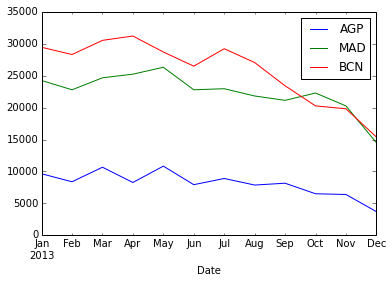

In [14]:
def getAirportCode(airportName):
    """Return airport code corresponding to input airport name 'airportName'"""
    
    # First perform a fuzzy find to get all potential matching airports
    geo_airports = GeoBase(data='airports', verbose=False)
    matchingList = geo_airports.fuzzyFind(airportName, 'name')
    
    # Then loop through results to get the righ corresponding code
    airportCode = ''
    for _,code in matchingList:
        if airportName in geo_airports.get(code, 'name'):
            airportCode = code
            break
            
    return airportCode


def getSearchesByAirportByMonth(airport, df_searches):
    """Return a data frame with total number of searches by month for 'airport'"""     
    
    # Select searches for 'airport'
    selection = df_searches[df_searches.Destination == airport]

    # Make 'Date' values 'dateTime' values
    dateTimeInfo = pd.to_datetime(selection.loc[:, 'Date'])
    selection.loc[:, 'Date'] = dateTimeInfo

    # Group searches by month
    gp = selection.groupby([pd.Grouper(key='Date', freq='1M')])

    totalPerMonth = gp.count()

    totalPerMonth.drop('Destination', axis=1, inplace=True)
    totalPerMonth.columns = [airport]

    return totalPerMonth


# Get index of columns 'arr_port' and 'pax' in order to load only those columns when loading the whole file
# This because entire file cannot be fully loaded due to memory limits
colList = df_searches.columns.tolist()

# Create a sub-list of columns to be loaded
colSubList = list()
for i in ['Date', 'Destination']:
    index = colList.index(i)
    colSubList.append(colList[index])

# Then load file
df_searches = pd.read_csv(searchesFileBz2, compression='bz2', error_bad_lines=False, sep='^', usecols=colSubList)

# Get airports code
malagaCode = getAirportCode('Malaga')
madridCode = getAirportCode('Madrid')
barcelonaCode = getAirportCode('Barcelona')

# Get number of searches per airport by month
malaga = getSearchesByAirportByMonth(malagaCode, df_searches)
madrid = getSearchesByAirportByMonth(madridCode, df_searches)
barcelona = getSearchesByAirportByMonth(barcelonaCode, df_searches)

# And plot
a_axis = malaga.plot()
madrid.plot(ax = a_axis)
barcelona.plot(ax = a_axis)

del df_searches